In [74]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy
import math
from matplotlib.backends.backend_pdf import PdfPages
pd.options.display.float_format = '{:,.3f}'.format

df = pd.read_csv('data/mobile.csv', index_col=0)
print(len(df))
df.head()

400


,battery_power,clock_speed,four_g,int_memory,n_cores,pc,ram,talk_time,touch_screen,wifi,price_range
0,1142,1.400,0,6,8,8,663,5,1,1,0
1,728,1.700,1,5,2,20,834,5,1,0,0
2,1868,0.500,1,40,8,17,298,17,1,0,0
3,890,2.200,0,44,8,13,751,3,0,0,0
4,1433,1.600,0,4,8,11,258,4,1,1,0


In [75]:
cols = ['battery_power', 'int_memory', 'ram']

df = df[cols]
df.head()

,battery_power,int_memory,ram
0,1142,6,663
1,728,5,834
2,1868,40,298
3,890,44,751
4,1433,4,258


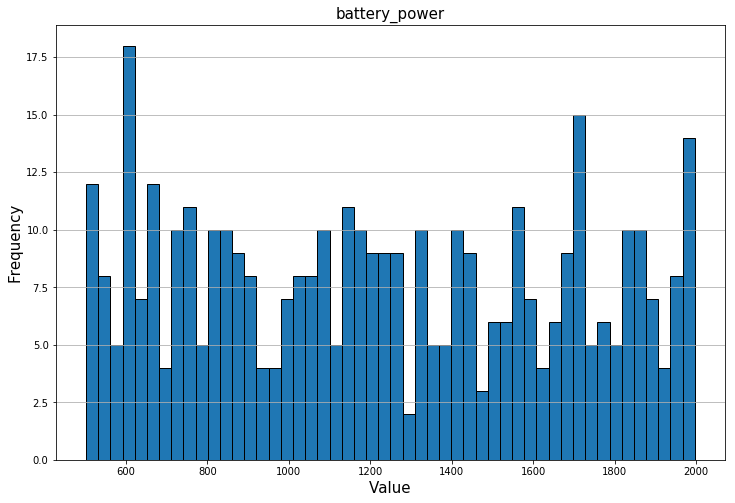

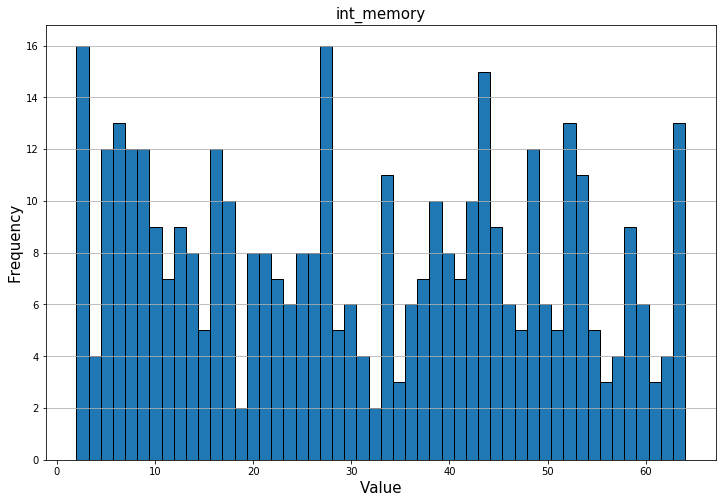

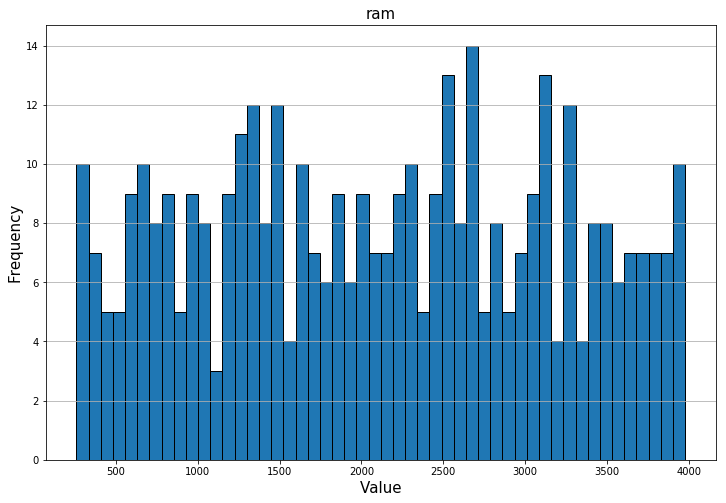

In [36]:
for col in cols:
    fig = plt.figure(figsize=(12,8))
    plt.title(col, size=15)
    plt.hist(df[col], bins=50, edgecolor='black', linewidth=1)
    plt.xlabel('Value', size=15)
    plt.ylabel('Frequency', size=15)
    plt.grid(axis='y')
    plt.show()

    pp = PdfPages('contingency_' + col + '.pdf', keep_empty=False)
    pp.savefig(fig)
    pp.close()


In [37]:
bat_pivots = [df['battery_power'].min(), 950, 1300, 1600, df['battery_power'].max()]
int_pivots = [df['int_memory'].min(), 19, 32, 55, df['int_memory'].max()]
ram_pivots = [df['ram'].min(), 1000, 2400, 3200, df['ram'].max()]

bat_pivots, int_pivots, ram_pivots

([502, 950, 1300, 1600, 1997],
 [2, 19, 32, 55, 64],
 [258, 1000, 2400, 3200, 3978])

In [100]:
def generate_cont_freq(pivots_list, initial_df, col_name):
    """
    pivots_list - лист пивотов
    initial_df - исходный датафрейм
    col_name - колонка (фича) которую категоризуем
    
    return:
    
    relative frequency table
    conditional frequency table
    
    """
    
    categories_inds = np.zeros(len(initial_df), dtype=int)
    ln = len(categories_inds)

    for i in range(len(bat_pivots) - 1):
        new_df = initial_df[initial_df[col_name] >= pivots_list[i]] # находим нужные элементы попадающие в промежуток
        new_df = new_df[new_df[col_name] <= pivots_list[i+1]]
        categories_inds[new_df.index.tolist()] = i # присваиваем тип категории соответствующим индексам
        
    zer = [0] * 5
    df_cats = pd.DataFrame({'Partitions': ['Part 1', 'Part 2', 'Part 3', 'Part 4', 'Total'], 
                               'Cat 1': zer, 'Cat 2': zer, 'Cat 3': zer, 'Cat 4': zer, 'Total': zer})
    df_cats = df_cats.set_index('Partitions')

    #заполняем табличку
    
    for i in range(4):
        cur_slice = np.arange(i * 100, i*100 + 100)
        for j in cur_slice:
            df_cats.iloc[i, categories_inds[j]] += 1

    df_cats['Total'] = [np.sum(df_cats.iloc[i,0:4]) for i in range(5)]
    colsum = df_cats.sum(axis=0).tolist()

    for i in range(5):
        df_cats.iloc[4,i] = colsum[i]
        
    # нормализация:    
    
    df_cats_freq = deepcopy(df_cats / ln)
    
    for i in range(4):
        for j in range(4):
            df_cats_freq.iloc[i,j] = df_cats_freq.iloc[i,j] / df_cats_freq.iloc[-1,j]
    
    df_cats_freq = df_cats_freq.iloc[:-1,:-1]
    return df_cats, df_cats / ln, df_cats_freq

In [101]:
def generate_quetlet(rel_freq_table):
    """
    rel_freq_table - relative frequency table
    """
    
    quet_table = deepcopy(rel_freq_table)
    ln = len(rel_freq_table)
    
    for i in range(ln-1):
        for j in range(ln-1):
            quet_table.iloc[i,j] = rel_freq_table.iloc[i,-1] * rel_freq_table.iloc[-1,j]
    
            
    quet_table = rel_freq_table.divide(quet_table)
    quet_table = quet_table.subtract(1)

    return quet_table.iloc[:-1,:-1]

In [108]:
def get_chi2(rel_freq_table):
    
    indep_table = deepcopy(rel_freq_table)
    ln = len(rel_freq_table)
    
    for i in range(ln-1):
        for j in range(ln-1):
            indep_table.iloc[i,j] = rel_freq_table.iloc[i,-1] * rel_freq_table.iloc[-1,j]
        
    subtr_table = rel_freq_table - indep_table
    subtr_table = subtr_table.multiply(subtr_table)
    chi_table = subtr_table.divide(indep_table)
    
#    chi_table = rel_freq_table.iloc[:-1,:-1].multiply(indep_table)
    return chi_table.values.sum()

In [114]:
def get_interval(chi2_value):
    freedom = 9
    t_95 = 16.92
    t_99 = 21.67
    
    ans_95 = t_95 / chi2_value
    ans_99 = t_99 / chi2_value
    
    return ans_95, ans_99

In [115]:
bat_cont_tab, bat_rel_freq, bat_cond_freq = generate_cont_freq(bat_pivots, df, 'battery_power')
bat_quet = generate_quetlet(bat_rel_freq)
bat_chi2_value = get_chi2(bat_rel_freq)
bat_chi2_value

0.06360754796904566

In [116]:
bat_cont_tab, bat_rel_freq, bat_cond_freq = generate_cont_freq(bat_pivots, df, 'battery_power')
bat_quet = generate_quetlet(bat_rel_freq)
bat_chi2_value = get_chi2(bat_rel_freq)
bat_num_95, bat_num_99 = get_interval(bat_chi2_value)

print('Contingency table:')
print(bat_cont_tab, '\n')
print('Relative frequency table:')
print(bat_rel_freq, '\n')
print('Conditional frequency table:')
print(bat_cond_freq, '\n')
print('Quetlet relative index table:')
print(bat_quet, '\n')
print('Chi-squared matrix:')
print(bat_chi2_table, '\n')
print('Chi-square value:')
print(bat_chi2_value, '\n')
print('Number of observation at 95% interval: N >', math.ceil(bat_num_95))
print('Number of observation at 99% interval: N >', math.ceil(bat_num_99))

Contingency table:
            Cat 1  Cat 2  Cat 3  Cat 4  Total
Partitions                                   
Part 1         44     25     10     21    100
Part 2         34     25     21     20    100
Part 3         37     19     16     28    100
Part 4         18     21     24     37    100
Total         133     90     71    106    400 

Relative frequency table:
            Cat 1  Cat 2  Cat 3  Cat 4  Total
Partitions                                   
Part 1      0.110  0.062  0.025  0.052  0.250
Part 2      0.085  0.062  0.052  0.050  0.250
Part 3      0.092  0.048  0.040  0.070  0.250
Part 4      0.045  0.052  0.060  0.092  0.250
Total       0.333  0.225  0.177  0.265  1.000 

Conditional frequency table:
            Cat 1  Cat 2  Cat 3  Cat 4
Partitions                            
Part 1      0.331  0.278  0.141  0.198
Part 2      0.256  0.278  0.296  0.189
Part 3      0.278  0.211  0.225  0.264
Part 4      0.135  0.233  0.338  0.349 

Quetlet relative index table:
            

In [113]:
ram_cont_tab, ram_rel_freq, ram_cond_freq = generate_cont_freq(ram_pivots, df, 'ram')
ram_quet = generate_quetlet(ram_rel_freq)
ram_chi2_value = get_chi2(ram_rel_freq)
ram_num_95, ram_num_99 = get_interval(ram_chi2_value)

print('Contingency table:')
print(ram_cont_tab, '\n')
print('Relative frequency table:')
print(ram_rel_freq, '\n')
print('Conditional frequency table:')
print(ram_cond_freq, '\n')
print('Quetlet relative index table:')
print(ram_quet, '\n')
print('Chi-square value:')
print(ram_chi2_value, '\n')
print('Number of observation at 95% interval: N >', math.ceil(ram_num_95))
print('Number of observation at 99% interval: N >', math.ceil(ram_num_99))

Contingency table:
            Cat 1  Cat 2  Cat 3  Cat 4  Total
Partitions                                   
Part 1         69     31      0      0    100
Part 2          8     87      5      0    100
Part 3          0     32     58     10    100
Part 4          0      1     31     68    100
Total          77    151     94     78    400 

Relative frequency table:
            Cat 1  Cat 2  Cat 3  Cat 4  Total
Partitions                                   
Part 1      0.172  0.077  0.000  0.000  0.250
Part 2      0.020  0.217  0.013  0.000  0.250
Part 3      0.000  0.080  0.145  0.025  0.250
Part 4      0.000  0.003  0.077  0.170  0.250
Total       0.193  0.378  0.235  0.195  1.000 

Conditional frequency table:
            Cat 1  Cat 2  Cat 3  Cat 4
Partitions                            
Part 1      0.896  0.205  0.000  0.000
Part 2      0.104  0.576  0.053  0.000
Part 3      0.000  0.212  0.617  0.128
Part 4      0.000  0.007  0.330  0.872 

Quetlet relative index table:
            